## MLflow Setup for 1st time
  * **Terminal 1:** Start the MLflow tracking server:
    ```bash
    mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 0.0.0.0 --port 5000
    ```
  * **Python:** Set the tracking URI in your code:
    ```python
    mlflow.set_tracking_uri("http://localhost:5000")
    ```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import mlflow
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.style.use('dark_background')
print("Using device : ",device)

Using device :  cuda


In [2]:
NOTEBOOK_DIR = Path().resolve()
BASE_DIR = NOTEBOOK_DIR.parents[1]

MODEL_OUTPUT_DIR = BASE_DIR / "models" / "1-residual-block-loss" 
MODEL_OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
MLFLOW_DIR = BASE_DIR / "mlruns"
print("Using mlflow dir :",MLFLOW_DIR.as_uri())
print("Models of this notebook will be saved at : ", MODEL_OUTPUT_DIR)

DATASET_DIR = BASE_DIR / "data" / "2-awgn"
INPUT_DIR = DATASET_DIR / "inputs"
TARGET_DIR = DATASET_DIR / "targets"
HEIGHT, WIDTH = 256, 256
IMAGE_SIZE = (HEIGHT, WIDTH)

import sys
sys.path.append(str(BASE_DIR))
import helper

Using mlflow dir : file:///C:/Users/SriRam.A/Documents/sr_proj/Hologram/mlruns
Models of this notebook will be saved at :  C:\Users\SriRam.A\Documents\sr_proj\Hologram\models\1-residual-block-loss


In [3]:
# Set MLflow tracking URI
mlflow.set_tracking_uri("http://localhost:5000")


In [4]:
class InterferogramDataset(Dataset):
    """Simple segmentation dataset for image-mask pairs"""
    
    def __init__(self, image_dir, mask_dir, transform=None, img_size=(512,512)):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.img_size = img_size
        
        # Get all image files
        valid_exts = {".jpg", ".jpeg", ".png"}
        self.images = sorted([f for f in self.image_dir.iterdir() if f.suffix.lower() in valid_exts])
        self.masks = sorted([f for f in self.mask_dir.iterdir() if f.suffix.lower() in valid_exts])
        
        assert len(self.images) == len(self.masks), "Images and masks count mismatch!"
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image and mask
        img = Image.open(self.images[idx]).convert('L')
        mask = Image.open(self.masks[idx]).convert('L')  # Grayscale
        
        # Resize
        img = img.resize(self.img_size, Image.NEAREST)
        mask = mask.resize(self.img_size, Image.NEAREST)
        
        # Convert to numpy
        img = np.array(img).astype(np.float32) / 255.0
        mask = np.array(mask).astype(np.float32) / 255.0
        
        # To tensor (C, H, W)
        img = torch.from_numpy(img).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dim
        
        return img, mask

In [5]:
# Create datasets
train_dataset = InterferogramDataset(INPUT_DIR, TARGET_DIR, img_size = IMAGE_SIZE)
BATCH_SIZE = 16
# Split into train/val (70/20)
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")


Train samples: 4900, Val samples: 2100


In [6]:
class ResidualBlock(nn.Module):
    """Residual block with two convolutions"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        
        # Skip connection
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        
    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)


In [7]:
class UNetResidualLite(nn.Module):
    """Lightweight U-Net with residual blocks for denoising / upsampling"""
    def __init__(self, in_channels=1, out_channels=1, base_filters=32):
        super().__init__()
        # Encoder
        self.enc1 = ResidualBlock(in_channels, base_filters)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = ResidualBlock(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = ResidualBlock(base_filters*2, base_filters*4)
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(base_filters*4, base_filters*2, 2, stride=2)
        self.dec2 = ResidualBlock(base_filters*4, base_filters*2)
        
        self.up1 = nn.ConvTranspose2d(base_filters*2, base_filters, 2, stride=2)
        self.dec1 = ResidualBlock(base_filters*2, base_filters)
        
        # Output
        self.out = nn.Conv2d(base_filters, out_channels, 1)
        
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        
        # Bottleneck
        b = self.bottleneck(self.pool2(e2))
        
        # Decoder
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        
        return self.out(d1)

In [8]:
BASE_FILTERS = 2
LR = 1e-4

SSIM (Structural Similarity Index) Ranges:
- 0.95 - 1.00: Excellent quality (near perfect reconstruction)
- 0.90 - 0.95: Very good quality (minor differences)
- 0.80 - 0.90: Good quality (noticeable but acceptable differences)
- 0.70 - 0.80: Fair quality (visible degradation)
- 0.60 - 0.70: Poor quality (significant artifacts)
- < 0.60: Very poor quality

PSNR (Peak Signal-to-Noise Ratio) Ranges:
- 40 dB: Excellent quality (near perfect)
- 30 - 40 dB: Good to very good quality
- 20 - 30 dB: Acceptable to fair quality
- < 20 dB: Poor quality

In [9]:
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_ssim = 0
    total_psnr = 0
    
    # Initialize metrics
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    
    for imgs, masks in tqdm(loader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        
        loss = criterion(outputs, masks)  
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate metrics
        total_ssim += ssim_metric(outputs, masks).item()
        total_psnr += psnr_metric(outputs, masks).item()
    
    n = len(loader)
    return total_loss / n, total_ssim / n, total_psnr / n

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_ssim = 0
    total_psnr = 0
    
    # Initialize metrics
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validation", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            
            loss = criterion(outputs, masks)  
            total_loss += loss.item()
            
            # Calculate metrics
            total_ssim += ssim_metric(outputs, masks).item()
            total_psnr += psnr_metric(outputs, masks).item()
    
    n = len(loader)
    return total_loss / n, total_ssim / n, total_psnr / n


https://medium.com/data-science/super-resolution-a-basic-study-e01af1449e13 - Total Variation Loss , SRCNN

In [11]:
criterion = nn.MSELoss()

In [ ]:
# run = mlflow.start_run(run_name=f"{criterion}_filters{BASE_FILTERS}") # To start new run
# run = mlflow.start_run(run_id="41d98256d804441ab866e3add4bb7f9e") # To continue previous run (get ID from visitng localhost)
# Log parameters
mlflow.log_params({
    "criterion": criterion,
    "base_filters": BASE_FILTERS,
    "learning_rate": LR,
    "batch_size": BATCH_SIZE,
    "image_height": HEIGHT,
    "image_width": WIDTH,
    "optimizer": "Adam",
    "scheduler": "ReduceLROnPlateau",
    "train_samples": len(train_dataset),
    "val_samples": len(val_dataset)
})
mlflow.pytorch.autolog()

In [13]:
model = UNetResidualLite(in_channels=1, out_channels=1, base_filters=BASE_FILTERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
summary = helper.inspect_model(
    model, 
    input_size=(1,1,HEIGHT,WIDTH),
    criterion=criterion,
    optimizer=optimizer,
    model_name="U-Net-Lite with Residual Connections"
)
mlflow.log_dict(summary, artifact_file="model_summary.json")


────────────────────────────────────── U-Net-Lite with Residual Connections ───────────────────────────────────────

Architecture Summary:

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
UNetResidualLite                         [1, 1, 256, 256]          [1, 1, 256, 256]          --
├─ResidualBlock: 1-1                     [1, 1, 256, 256]          [1, 2, 256, 256]          --
│    └─Conv2d: 2-1                       [1, 1, 256, 256]          [1, 2, 256, 256]          4
│    └─Conv2d: 2-2                       [1, 1, 256, 256]          [1, 2, 256, 256]          20
│    └─BatchNorm2d: 2-3                  [1, 2, 256, 256]          [1, 2, 256, 256]          4
│    └─ReLU: 2-4                         [1, 2, 256, 256]          [1, 2, 256, 256]          --
│    └─Conv2d: 2-5                       [1, 2, 256, 256]          [1, 2, 256, 256]          38
│    └─BatchNorm2d: 2-6                  [1, 2, 256, 256]          [1, 2, 256, 256]          4
│    └─ReLU: 2-7                         [1, 2, 256, 256]          [1, 2, 256, 256]          --
├─MaxPool2d: 1-2                      

MACs and Parameters (ptflops):

╷             
  Metric               │      Value  
 ══════════════════════╪════════════ 
  Total Parameters     │      2,065  
  Trainable Parameters │      2,065  
  Optimizer Params     │      2,065  
  Model Size (MB)      │      0.008  
  MACs                 │ 35.88 MMac  
  FLOPs (approx)       │ 35.88 MMac  
  Loss Function        │    MSELoss  
  Optimizer            │       Adam  
                       ╵

In [14]:
total_epochs = 0
history = {
    "train_loss": [],
    "train_ssim": [],
    "train_psnr": [],
    "val_loss": [],
    "val_ssim": [],
    "val_psnr": [],
    "learning_rate": []
}
best_val_loss = float("inf")

In [31]:
epochs = 1
for epoch in range(epochs):
    train_loss, train_ssim, train_psnr = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_ssim, val_psnr = validate(model, val_loader, criterion, device)
    
    # Log metrics to MLflow
    mlflow.log_metrics({
        "train_loss": train_loss,
        "train_ssim": train_ssim,
        "train_psnr": train_psnr,
        "val_loss": val_loss,
        "val_ssim": val_ssim,
        "val_psnr": val_psnr,
        "learning_rate": optimizer.param_groups[0]['lr']
    }, step=epoch)

    # -------------------------------------
    # Store metrics in history dictionary
    # -------------------------------------
    history["train_loss"].append(train_loss)
    history["train_ssim"].append(train_ssim)
    history["train_psnr"].append(train_psnr)
    history["val_loss"].append(val_loss)
    history["val_ssim"].append(val_ssim)
    history["val_psnr"].append(val_psnr)
    history["learning_rate"].append(optimizer.param_groups[0]['lr'])

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:2d}/{epochs} | "
          f"Loss: {train_loss:.6f}/{val_loss:.6f} | "
          f"SSIM: {train_ssim:.3f}/{val_ssim:.3f} | "
          f"PSNR: {train_psnr:5.1f}/{val_psnr:5.1f} dB", end="")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_path = MODEL_OUTPUT_DIR / f"best_model_{criterion}.pth"
        torch.save(model.state_dict(), model_path)
        mlflow.log_artifact(str(model_path))
        print(" ✓", end="")
        
total_epochs += epochs
print("Total epochs till now :",total_epochs)

Epoch  1/1 | Loss: 0.001916/0.001313 | SSIM: 0.819/0.829 | PSNR:  27.5/ 29.0 dBTotal epochs till now : 51


In [19]:

from mlflow.models import infer_signature
# Create dummy example
example_input_tensor = torch.randn(1, 1, HEIGHT, WIDTH, device=device)
# Convert to numpy for MLflow (IMPORTANT)
input_example = example_input_tensor.cpu().numpy()
# Forward pass to capture output for signature
with torch.no_grad():
    example_output = model(example_input_tensor).cpu().numpy()
signature = infer_signature(
    input_example,
    example_output
)
# Log the model
mlflow.pytorch.log_model(
    model,
    name="unet_residual_lite-100",
    input_example=input_example,   # <-- now numpy, valid type
    signature=signature
)
# Log final best metrics
mlflow.log_metrics({
    "best_val_loss": best_val_loss
})
print(f"\n{criterion} Summary:")
print(f"  Best Val Loss: {best_val_loss:.4f}")
print(f"  MLflow Run ID: {mlflow.active_run().info.run_id}")

2025/11/16 00:03:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/16 00:03:32 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.22.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
c:\Users\SriRam.A\miniconda3\envs\pytorch-miniconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .a


MSELoss() Summary:
  Best Val Loss: 0.0013
  MLflow Run ID: 41d98256d804441ab866e3add4bb7f9e


In [ ]:
# ! ipynb-py-convert 2-residual-block-loss.ipynb main.py

In [ ]:
# Plot for each criterion in HISTORY using subplot
plt.figure(figsize=(16, 4))

# 1st subplot: Loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title(f'{criterion} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(False, alpha=0.3)
plt.legend()

# 2nd subplot: SSIM
plt.subplot(1, 3, 2)
plt.plot(history['train_ssim'], label='Training SSIM', color='green', linewidth=2)
plt.plot(history['val_ssim'], label='Validation SSIM', color='orange', linewidth=2)
plt.title(f'{criterion} - SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.grid(False, alpha=0.3)
plt.legend()

# 3rd subplot: PSNR
plt.subplot(1, 3, 3)
plt.plot(history['train_psnr'], label='Training PSNR', color='purple', linewidth=2)
plt.plot(history['val_psnr'], label='Validation PSNR', color='brown', linewidth=2)
plt.title(f'{criterion} - PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.grid(False, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Print final values
print(f"{criterion} - Final Metrics:")
print(f"  Loss:  Train={history['train_loss'][-1]:.4f}, Val={history['val_loss'][-1]:.4f}")
print(f"  SSIM:  Train={history['train_ssim'][-1]:.4f}, Val={history['val_ssim'][-1]:.4f}")
print(f"  PSNR:  Train={history['train_psnr'][-1]:.2f} dB, Val={history['val_psnr'][-1]:.2f} dB")
print("-" * 60)

: 

Original pred shape: (1, 1, 256, 256)
After squeeze shape: (256, 256)



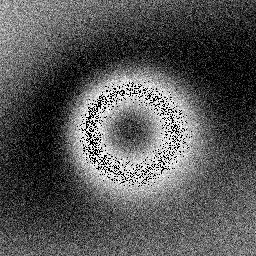
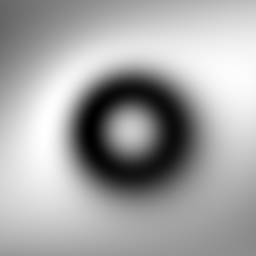
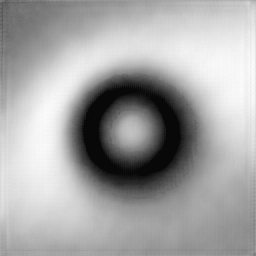

In [50]:
# Load best model
model.load_state_dict(torch.load(MODEL_OUTPUT_DIR / f"best_model_{criterion}.pth"))
model.eval()
# Get random images
input_path, target_path = helper.get_images_from_dirs([INPUT_DIR, TARGET_DIR])
# Load and preprocess
img_pil = Image.open(input_path).convert('L')
mask_pil = Image.open(target_path).convert('L')

img_resized = img_pil.resize((HEIGHT, WIDTH))
img_tensor = torch.from_numpy(np.array(img_resized).astype(np.float32) / 255.0).unsqueeze(0).to(device)
img_tensor = img_tensor.unsqueeze(0)  # This makes it (1, 1, H, W)

# Predict
with torch.no_grad():
    pred = model(img_tensor).cpu().numpy()

print(f"Original pred shape: {pred.shape}")
pred = pred.squeeze() # This converts (1, 1, 256, 256) -> (256, 256)
print(f"After squeeze shape: {pred.shape}")

# Convert for visualization
img_np = np.array(img_resized)
mask_np = np.array(mask_pil.resize((HEIGHT, WIDTH))) / 255.0

# Display using helper
helper.show_grid({
    'Noise Mask': (img_np * 255).astype(np.uint8),
    'Target Mask': (mask_np * 255).astype(np.uint8),
    'Predicted Mask': (pred * 255).astype(np.uint8),  # Now this is 2D
}, grid="row", width=1200)

In [38]:
import mlflow
import numpy as np
from PIL import Image
import io

def log_images_to_mlflow(images_dict, artifact_path="predictions"):
    """
    Log images to MLflow as individual artifacts
    """
    for name, img_array in images_dict.items():
        # Convert numpy array to PIL Image
        if img_array.dtype == np.float32 or img_array.dtype == np.float64:
            img_array = (img_array * 255).astype(np.uint8)
        
        pil_img = Image.fromarray(img_array)
        # Save to bytes buffer
        buf = io.BytesIO()
        pil_img.save(buf, format='PNG')
        # Log as artifact
        mlflow.log_image(pil_img, f"{artifact_path}/{name}.png")


images_to_log = {
    'noise_mask': (img_np * 255).astype(np.uint8),
    'target_mask': (mask_np * 255).astype(np.uint8),
    'predicted_mask': (pred * 255).astype(np.uint8),
}
log_images_to_mlflow(images_to_log, "validation_predictions")


In [51]:
# mlflow.log_params({
#     "total_epochs" : 50
# })

In [52]:
mlflow.end_run()
run = mlflow.get_run(run.info.run_id)
print(f"run_id: {run.info.run_id}; status: {run.info.status}")
print("--")
# Check for any active runs
print(f"Active run: {mlflow.active_run()}")

🏃 View run MSELoss()_filters2 at: http://localhost:5000/#/experiments/0/runs/41d98256d804441ab866e3add4bb7f9e
🧪 View experiment at: http://localhost:5000/#/experiments/0
run_id: 41d98256d804441ab866e3add4bb7f9e; status: FINISHED
--
Active run: None
